# Figure 2: PCA residuals with fake planets

## 1. Imports

In [1]:
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
color_map = cmocean.cm.ice

from applefy.detections.contrast import Contrast
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

from s4hci.detection_limits.applefy_wrapper import PCADataReductionGPU
from s4hci.utils.data_handling import read_s4hci_root_dir
from s4hci.utils.setups import contrast_grid_setup_1

## 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_s4hci_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [4]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [5]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [7]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [8]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

## 3. Create Contrast Instance

In [9]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor,
    checkpoint_dir=experiment_root_dir)

In [10]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [11]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


## 4. Restore PCA results

In [12]:
pca_numbers = np.concatenate(
    [np.arange(0, 30, 2)[1:],
     np.arange(30, 100, 10),
     np.arange(100, 200, 20),
     np.arange(200, 550, 50)])

pca_algorithm_function = PCADataReductionGPU(
        approx_svd=8000,
        pca_numbers=pca_numbers,
        device="cpu",
        work_dir=None,
        special_name="stacked_05",
        verbose=False)

In [13]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_algorithm_function,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [03:13<00:00,  4.88it/s]

[DONE]


## 5. Select example residuals

In [14]:
contrast_instance.results_dict['stacked_05_PCA_002_components'][1][0]

{'type': 'TP estimation',
 'flux_ratio': 0.01,
 'separation': 5.4,
 'planet_position': (50.4, 45.0, 5.4, 0.0),
 'exp_id': '0001a'}

In [61]:
def find_residual(tmp_results, target_separation, target_contrast, target_letter):
    for i in tmp_results:
        if i[0]["exp_id"] == "0000":
            continue

        tmp_separation = np.round(np.round(i[0]["separation"] / fwhm, 2), 2)
        tmp_contrast = np.round(flux_ratio2mag(i[0]["flux_ratio"]), 2)
        tmp_letter = i[0]["exp_id"][-1:]

        if (tmp_separation == target_separation) & \
            (tmp_contrast == target_contrast) & \
            (tmp_letter == target_letter):

            return i[1], i[0]["planet_position"]

In [62]:
setup_1 = (3.0, 9, "c")
setup_2 = (10.0, 12.5, "a")

In [63]:
setup_1_residuals = []
setup_2_residuals = []

for tmp_pca_number in tqdm(pca_numbers):
    tmp_name = "stacked_05_PCA_" + str(tmp_pca_number).zfill(3) + "_components"
    tmp_results = contrast_instance.results_dict[tmp_name]
    
    setup_1_residual = find_residual(tmp_results, *setup_1)
    setup_2_residual = find_residual(tmp_results, *setup_2)
    
    setup_1_residuals.append(setup_1_residual)
    setup_2_residuals.append(setup_2_residual)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.73it/s]


## 6. Plot the results

In [64]:
def add_colorbar(axis_in, plot_in, left=True):
    if left:
        tick_side = "left"
    else:
        tick_side = "right"
    divider = make_axes_locatable(axis_in)
    cax = divider.new_horizontal(size="5%", pad=0.1, pack_start=left)
    fig.add_axes(cax)
    
    cbar = fig.colorbar(plot_in, cax=cax, 
                 orientation="vertical")
    cbar.ax.yaxis.set_ticks_position(tick_side)
    axis_in.set_xticks([]) 
    axis_in.set_yticks([]) 
    cbar.ax.tick_params(labelsize=10)

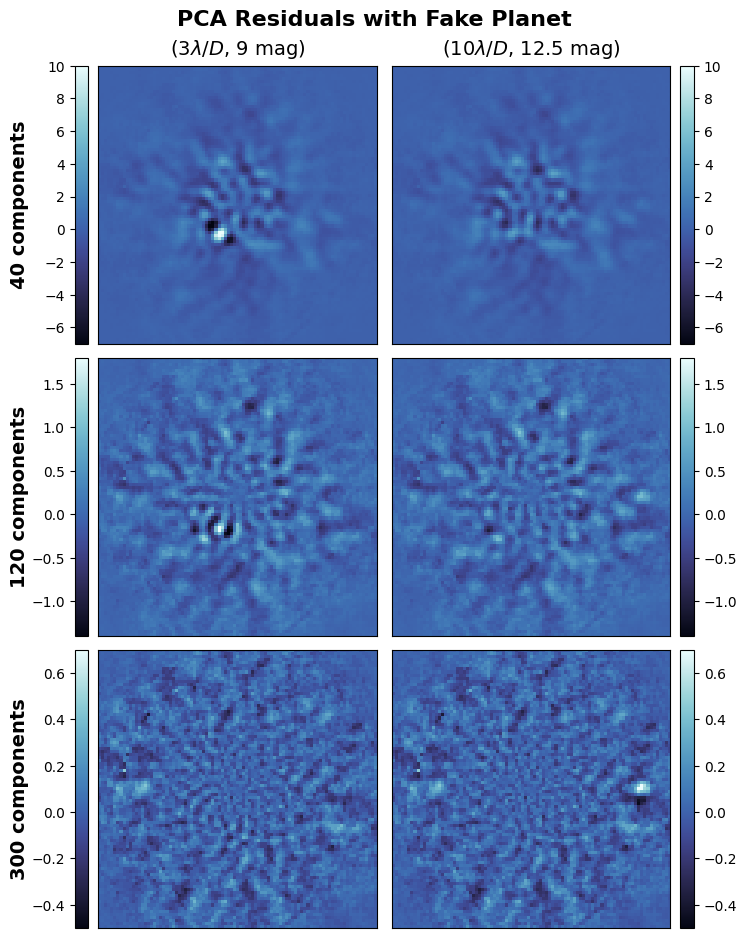

In [65]:
fig = plt.figure(constrained_layout=False, figsize=(8, 11.2))
gs0 = fig.add_gridspec(3, 2,hspace=0.05, wspace=0.05) # height_ratios=[1, 1]

pca_idx = [15, 22, 28]
axis_pca_inner_1 = fig.add_subplot(gs0[0, 0])
axis_pca_inner_2 = fig.add_subplot(gs0[1, 0])
axis_pca_inner_3 = fig.add_subplot(gs0[2, 0])
axis_pca_outer_1 = fig.add_subplot(gs0[0, 1])
axis_pca_outer_2 = fig.add_subplot(gs0[1, 1])
axis_pca_outer_3 = fig.add_subplot(gs0[2, 1])

# PCA inner plots -----------------
plot1 = axis_pca_inner_1.imshow(
    setup_1_residuals[pca_idx[0]][0], 
    cmap=color_map, origin='lower',
    vmin=-7, vmax=10.0
)
add_colorbar(axis_pca_inner_1, plot1, True)

plot2 = axis_pca_inner_2.imshow(
    setup_1_residuals[pca_idx[1]][0], 
    cmap=color_map, origin='lower',
    vmin=-1.4, vmax=1.8
)
add_colorbar(axis_pca_inner_2, plot2, True)

plot3 = axis_pca_inner_3.imshow(
    setup_1_residuals[pca_idx[2]][0], 
    cmap=color_map, origin='lower',
    vmin=-0.5, vmax=0.7
)
add_colorbar(axis_pca_inner_3, plot3, True)


# PCA outer plots -----------------
plot4 = axis_pca_outer_1.imshow(
    setup_2_residuals[pca_idx[0]][0],
    cmap=color_map, origin='lower',
    vmin=-7, vmax=10.0
)
add_colorbar(axis_pca_outer_1, plot4, False)

plot5 = axis_pca_outer_2.imshow(
    setup_2_residuals[pca_idx[1]][0],
    cmap=color_map, origin='lower',
    vmin=-1.4, vmax=1.8
)
add_colorbar(axis_pca_outer_2, plot5, False)

plot6 = axis_pca_outer_3.imshow(
    setup_2_residuals[pca_idx[2]][0],
    cmap=color_map, origin='lower',
    vmin=-0.5, vmax=0.7
)
add_colorbar(axis_pca_outer_3, plot6, False)


# Titles -----------------
axis_pca_inner_1.set_title(
    "($3 \lambda / D$, $9$ mag)",
    fontsize=14, y=1.01)

axis_pca_outer_1.set_title(
    "($10 \lambda / D$, $12.5$ mag)",
    fontsize=14, y=1.01)

axis_pca_inner_1.set_ylabel(
    str(pca_numbers[pca_idx][0]) + " components", fontsize=14, 
    fontweight="bold",labelpad=50)

axis_pca_inner_2.set_ylabel(
    str(pca_numbers[pca_idx][1]) + " components", fontsize=14, 
    fontweight="bold",labelpad=50)

axis_pca_inner_3.set_ylabel(
    str(pca_numbers[pca_idx][2]) + " components", fontsize=14, 
    fontweight="bold",labelpad=50)

st = fig.suptitle(
    "PCA Residuals with Fake Planet",
    fontsize=16, fontweight="bold", y=0.93)

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/02_pca_residuals.pdf", bbox_inches='tight')

### The same but horizontal layout

In [66]:
def add_colorbar(axis_in, plot_in, left=True):
    if left:
        tick_side = "left"
    else:
        tick_side = "right"
        
    divider = make_axes_locatable(axis_in)
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=left)
    fig.add_axes(cax)
    
    cbar = fig.colorbar(plot_in, cax=cax, 
                 orientation="horizontal")
    cbar.ax.yaxis.set_ticks_position(tick_side)
    cbar.ax.tick_params(labelsize=10)

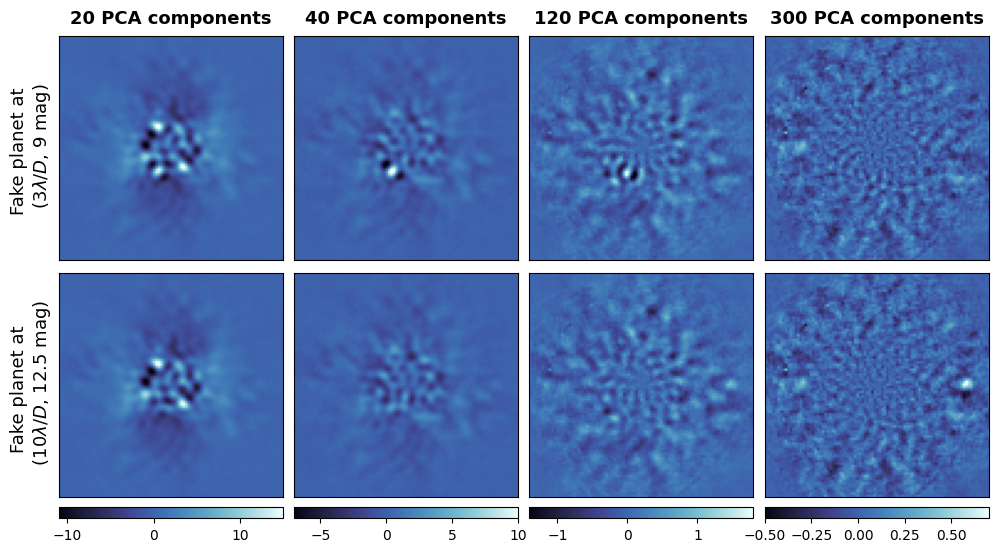

In [111]:
fig = plt.figure(constrained_layout=False, figsize=(12, 6.28))
gs0 = fig.add_gridspec(2, 4, hspace=0.05, wspace=0.05, height_ratios=[1, 1.1])

pca_idx = [9, 15, 22, 28]
axis_pca_inner_1 = fig.add_subplot(gs0[0, 0])
axis_pca_inner_2 = fig.add_subplot(gs0[0, 1])
axis_pca_inner_3 = fig.add_subplot(gs0[0, 2])
axis_pca_inner_4 = fig.add_subplot(gs0[0, 3])

axis_pca_outer_1 = fig.add_subplot(gs0[1, 0])
axis_pca_outer_2 = fig.add_subplot(gs0[1, 1])
axis_pca_outer_3 = fig.add_subplot(gs0[1, 2])
axis_pca_outer_4 = fig.add_subplot(gs0[1, 3])

# PCA inner plots -----------------
plot1 = axis_pca_inner_1.imshow(
    setup_1_residuals[pca_idx[0]][0], 
    cmap=color_map, origin='lower',
    vmin=-11, vmax=15.0
)
#add_colorbar(axis_pca_inner_1, plot1, True)

plot2 = axis_pca_inner_2.imshow(
    setup_1_residuals[pca_idx[1]][0], 
    cmap=color_map, origin='lower',
    vmin=-7, vmax=10
)
#add_colorbar(axis_pca_inner_2, plot2, True)

plot3 = axis_pca_inner_3.imshow(
    setup_1_residuals[pca_idx[2]][0], 
    cmap=color_map, origin='lower',
    vmin=-1.4, vmax=1.8
)
#add_colorbar(axis_pca_inner_3, plot3, True)

plot4 = axis_pca_inner_4.imshow(
    setup_1_residuals[pca_idx[3]][0], 
    cmap=color_map, origin='lower',
    vmin=-0.5, vmax=0.7
)
#add_colorbar(axis_pca_inner_3, plot3, True)


# PCA outer plots -----------------
plot5 = axis_pca_outer_1.imshow(
    setup_2_residuals[pca_idx[0]][0],
    cmap=color_map, origin='lower',
    vmin=-11, vmax=15.0
)
add_colorbar(axis_pca_outer_1, plot5, True)

plot6 = axis_pca_outer_2.imshow(
    setup_2_residuals[pca_idx[1]][0],
    cmap=color_map, origin='lower',
    vmin=-7, vmax=10.0
)
add_colorbar(axis_pca_outer_2, plot6, True)

plot7 = axis_pca_outer_3.imshow(
    setup_2_residuals[pca_idx[2]][0],
    cmap=color_map, origin='lower',
    vmin=-1.4, vmax=1.8
)
add_colorbar(axis_pca_outer_3, plot7, True)

plot8 = axis_pca_outer_4.imshow(
    setup_2_residuals[pca_idx[3]][0],
    cmap=color_map, origin='lower',
    vmin=-0.5, vmax=0.7
)
add_colorbar(axis_pca_outer_4, plot8, True)


# Turn of imshow ticks
for tmp_axis in [
    axis_pca_inner_1, axis_pca_inner_2, axis_pca_inner_3, axis_pca_inner_4,
    axis_pca_outer_1, axis_pca_outer_2, axis_pca_outer_3, axis_pca_outer_4]:
    
    tmp_axis.set_xticks([]) 
    tmp_axis.set_yticks([]) 


# Titles -----------------
axis_pca_inner_1.set_ylabel(
    "Fake planet at \n ($3 \lambda / D$, $9$ mag)",
    fontsize=13)

axis_pca_outer_1.set_ylabel(
    "Fake planet at \n ($10 \lambda / D$, $12.5$ mag)",
    fontsize=13)

axis_pca_inner_1.set_title(
    str(pca_numbers[pca_idx][0]) + " PCA components", fontsize=13, 
    fontweight="bold", y=1.02)

axis_pca_inner_2.set_title(
    str(pca_numbers[pca_idx][1]) + " PCA components", fontsize=13, 
    fontweight="bold", y=1.02)

axis_pca_inner_3.set_title(
    str(pca_numbers[pca_idx][2]) + " PCA components", fontsize=13, 
    fontweight="bold", y=1.02)

axis_pca_inner_4.set_title(
    str(pca_numbers[pca_idx][3]) + " PCA components", fontsize=13, 
    fontweight="bold", y=1.02)

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/02_pca_residuals.pdf", bbox_inches='tight')